# NLP2 project 1: Lexical Alignment
###  Kai Liang, Yijie Zhang, Billy Chan

In [1]:
# -*- coding:utf-8 -*-
import sys
import os
import numpy as np
import operator
import aer
from collections import *
from decimal import *
from aer import read_naacl_alignments
import matplotlib.pyplot as plt

## * Read Data

In [2]:
# reading training data
en_train = open('./training/hansards.36.2.e', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding
fr_train = open('./training/hansards.36.2.f', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding

# reading validation data
en_val = open('./validation/dev.e', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding
fr_val = open('./validation/dev.f', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding

# reading test data
en_test = open('./testing/test/test.e', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding
fr_test = open('./testing/test/test.f', mode='r', encoding='utf-8').read().splitlines() # utf-8 encoding

# path of gold standrad of validation data
path_val = 'validation/dev.wa.nonullalign'

# path of gold standrad of testing data
path_test = 'testing/answers/test.wa.nonullalign'

print('Number of English sentences in training set:', len(en_train))
print('Number of French sentences in training set:', len(fr_train))
print('Number of English sentences in validation set:', len(en_val))
print('Number of French sentences in validation set:', len(fr_val))
print('Number of English sentences in testing set:', len(en_test))
print('Number of French sentences in testing set:', len(fr_test))

Number of English sentences in training set: 231164
Number of French sentences in training set: 231164
Number of English sentences in validation set: 37
Number of French sentences in validation set: 37
Number of English sentences in testing set: 447
Number of French sentences in testing set: 447


In [3]:
print('The first English sentence:', en_train[0])

The first English sentence: 36 th Parliament , 2 nd Session 


In [4]:
print('The first French sentence:', fr_train[0])

The first French sentence: 36 e Législature , 2 ième Session 


In [5]:
# theta = np.load('theta_0.npy').item()
# theta_10 = np.load('theta_10.npy').item()
# count_f_e_0 = np.load('count_f_e_0.npy').item()
# count_e_0 = np.load('count_e_0.npy').item()

# '''
# np.save('theta_0.npy', theta_0) 
# np.save('count_f_e_0.npy', count_f_e) 
# np.save('count_e_0.npy', count_e)
# np.save('theta_10.npy', theta) 
# '''

## * Data Preprocessing

In [6]:
# split sentence into words
def preprocess(s):
    return s.split()

In [7]:
# preprocess training data, validation data and testing data
for i in range(len(en_train)):
    en_train[i] = preprocess(en_train[i])
    en_train[i] = ['NULLINDICATOR'] + en_train[i]
    fr_train[i] = preprocess(fr_train[i])
for i in range(len(en_val)):
    en_val[i] = preprocess(en_val[i])
    fr_val[i] = preprocess(fr_val[i])
for i in range(len(en_test)):
    en_test[i] = preprocess(en_test[i])
    fr_test[i] = preprocess(fr_test[i])

In [8]:
print('Proccessed training example sentence:', fr_train[0])
print('Proccessed validation example sentence:', fr_val[0])
print('Proccessed testing example sentence:', fr_test[0])

Proccessed training example sentence: ['36', 'e', 'Législature', ',', '2', 'ième', 'Session']
Proccessed validation example sentence: ['chacun', 'en', 'lui', '-', 'même', 'est', 'très', 'complexe', 'et', 'le', 'lien', 'entre', 'les', 'deux', 'le', 'est', 'encore', 'davantage', 'de', 'sorte', 'que', 'pour', 'beaucoup', 'la', 'situation', 'présente', 'est', 'confuse', '.']
Proccessed testing example sentence: ['2', '.']


## * Log-likelihood Computation

In [9]:
def get_loglikelihood(en_train, fr_train, theta):
    N = len(en_train)
    loglikelihood_total = 0
    for n in range(N): # for all pairs of sentences
        
        cleaned_en_n = en_train[n]
        len_en_n = len(cleaned_en_n)
        
        cleaned_fr_n = fr_train[n]
        len_fr_n = len(cleaned_fr_n)
        
        loglikelihood_n = np.log(len_fr_n/len_en_n) + len_fr_n * np.log(1/len_en_n)
        for fr_word in cleaned_fr_n: # every french word
            # find the english word that maximize p(fr/en) 
            max_p_fe = 0
            for en_word in cleaned_en_n:
                p_fe = theta[en_word][fr_word]
                if p_fe > max_p_fe:
                    max_p_fe = p_fe
            
            loglikelihood_n += np.log(float(max_p_fe))
        loglikelihood_total += loglikelihood_n
    return loglikelihood_total

## * Compute AER

In [10]:
def compute_aer(en_data, fr_data, path, theta):
    # compute AER score for the given data
    predictions = []
    for s in range(len(en_data)):
        alignments=[]
        l_e = len(en_data[s])
        l_f = len(fr_data[s])
        for i in range(l_f):
            vals = []
            for j in range(l_e):
                vals.append(theta[en_data[s][j]][fr_data[s][i]])
            max_idx = vals.index(max(vals))
            alignments.append((max_idx+1, i+1))
        predictions.append(set(alignments))
    gold_sets = read_naacl_alignments(path)
    metric = aer.AERSufficientStatistics()
    for gold, pred in zip(gold_sets, predictions):
        metric.update(sure=gold[0], probable=gold[1], predicted=pred)
    # AER
    return metric.aer(), predictions  

## * Export NAACL

In [11]:
def export_naacl(predictions, filename):
    with open('{}.naacl'.format(filename), 'w') as file:
        for index, sen in enumerate(predictions):
            for align in sen:
                file.write('{} {} {} S\n'.format(index+1, align[0], align[1]))
    file.close()

## * IBM1 - Initialize Parameters

In [12]:
def init_theta(en_train, fr_train):
    # initialize theta
    theta = defaultdict(lambda: defaultdict(lambda: Decimal(0)))
    N = len(en_train)
    for n in range(N):
        cleaned_en_n = en_train[n]
        cleaned_fr_n = fr_train[n]     
        for j_en_word in cleaned_en_n:
            for i_fr_word in cleaned_fr_n:
                theta[j_en_word][i_fr_word] = 0      
    for en_word in theta:
        count = len(theta[en_word])
        for fr_word in theta[en_word]:
            theta[en_word][fr_word] = Decimal(1 / count)
    return theta

In [13]:
theta = init_theta(en_train, fr_train)
print('Number of English words in the training set:', len(theta))

Number of English words in the training set: 36636


## * IBM1 - Update via EM

In [14]:
def train_EM(en_train, fr_train, theta, en_val, fr_val, en_test, fr_test, path, K):
    N = len(en_train)
    AER = []
    iteration = []
    t_log = []
    for k in range(K):
        iteration.append(k+1)
        print('Iteration {}:'.format(k))
        count_f_e = defaultdict(lambda: Decimal(0))
        count_e = defaultdict(lambda: Decimal(0))
        for n in range(N):
            cleaned_en_n = en_train[n]
            cleaned_fr_n = fr_train[n]
            for fr in cleaned_fr_n:
                Z = 0
                for en in cleaned_en_n:
                    Z += theta[en][fr]
                for en in cleaned_en_n:
                    c = theta[en][fr] / Z
                    count_f_e[(fr, en)] += c
                    count_e[en] += c
        for (f, e) in count_f_e:
            theta[e][f] = count_f_e[(f, e)] / count_e[e]
        # compute AER on the validation set
        aer, _ = compute_aer(en_val, fr_val, path, theta)
        print('Validation AER:', aer)
        AER.append(aer)
        
        log_likelihood = get_loglikelihood(en_train, fr_train, theta)
        t_log.append(log_likelihood)
        print("Training log-likelihood:", log_likelihood)
#     np.save("theta_10.npy", theta)
    return theta, AER, t_log, iteration

In [15]:
theta_10, AER, t_log, iteration = train_EM(en_train, fr_train, theta, en_val, fr_val, en_test, fr_test, path_val, K=10)

Iteration 0:
Validation AER: 0.3748819641170916
Training log-likelihood: -30865714.014653254
Iteration 1:
Validation AER: 0.33994334277620397
Training log-likelihood: -26202135.770782452
Iteration 2:
Validation AER: 0.3305004721435316
Training log-likelihood: -24288806.982518796
Iteration 3:
Validation AER: 0.33144475920679883
Training log-likelihood: -23377239.632227864
Iteration 4:
Validation AER: 0.3305004721435316
Training log-likelihood: -22847765.255030096
Iteration 5:
Validation AER: 0.3295561850802644
Training log-likelihood: -22505412.76867087
Iteration 6:
Validation AER: 0.32672332389046266
Training log-likelihood: -22268720.140491456
Iteration 7:
Validation AER: 0.32766761095373
Training log-likelihood: -22097046.26241591
Iteration 8:
Validation AER: 0.3286118980169972
Training log-likelihood: -21968133.330750603
Iteration 9:
Validation AER: 0.32483474976392823
Training log-likelihood: -21868134.508379217


## * Testing

In [16]:
aer_test, test_alignment = compute_aer(en_test, fr_test, path_test, theta_10)
print('Test AER:', aer_test)
export_naacl(test_alignment, 'result/ibm1.mle')
print('File saved successfully.')

Test AER: 0.296465802186626
File saved successfully.


## * Plotting

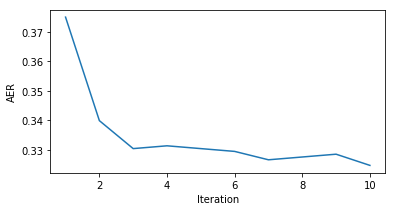

In [56]:
aer_ibm1 = plt.figure(figsize = (6, 3))
plt.plot(iteration, AER)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm1.savefig('./result/aer-IBM1.eps')

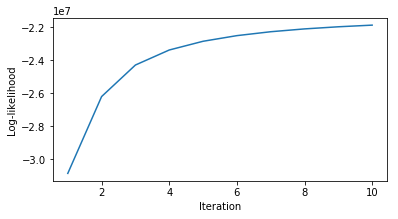

In [57]:
loss_ibm1 = plt.figure(figsize = (6, 3))
plt.plot(iteration, t_log)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm1.savefig('./result/loglikelihood-IBM1.eps')

## * IBM2 - Initialize Jump Functions

In [83]:
import random
#defined some preparatory functions 

# function for defining the distance of jumping 
# e.g. aligning from 1st of fr sent to the last word of en sent is the max jump (jump = k) to the right
# e.g. aligning the middle word of fr sent to the middle word of en sent means jump = 0
def jump(i, j, I, J): #fr position, en pos, len(fr_sent_), len(en_sent_)
    return i-np.floor(I * j / J)

def init_random(theta, seed):
    random.seed(seed)
    for en in theta:
        s = 0
        for fr in theta[en]:
            theta[en][fr] = Decimal(random.random())
            s += theta[en][fr]
        for fr in theta[en]:
            theta[en][fr] /= s
    return theta

# given set of english sentence (in order to get the value of max jump) 
# return the theta of jumps (the prob of each jump)
def theta_jump_init(en_sents, theta_jump=None, seed=None):
    # first get the range of the jumps -k, -k+1, ...-1, 0, 1,...k-1, k, 
    # where k is the length of the longest en_sent 
    max_jump_value = max(len(x) for x in en_sents) 
    
    # as we have -k, -k+1,...0 ...k-1, k, ie 2k+1 categories of jumps
    if theta_jump == None:
        prob = Decimal(1 / (max_jump_value * 2 + 1 ))
        # theta_jump = {k:uniform_prob for k in range(-max_jump_value, max_jump_value+1)} # from -k to k
        # use default dict instead
        theta_jump = defaultdict(lambda: prob) # from -k to k
    else:
        random.seed(seed)
        theta_jump = defaultdict(lambda: Decimal(random.random()))
    
    return theta_jump, max_jump_value

## * IBM2 - Update via EM

In [20]:
def train_EM_ibm2(en_train, fr_train, theta, en_val, fr_val, en_test, fr_test, path, K, theta_jump=None, seed=None):
    N = len(en_train)
    AER = []
    iteration = []
    t_log = []
    
    #init jump_theta if not given:
    if theta_jump==None:
        theta_jump, max_jump_value = theta_jump_init(en_train) # a default dict for all possible jump distance
    else:
        theta_jump, max_jump_value = theta_jump_init(en_train, theta_jump, seed) # a default dict for all possible jump distance
        
    for k in range(K):
        iteration.append(k+1)
        print('Iteration {}:'.format(k))
        count_f_e = defaultdict(lambda: Decimal(0))
        count_e = defaultdict(lambda: Decimal(0))
        count_jump = defaultdict(lambda: Decimal(0)) # +count prob for each jump distance
        count_jump_total = 0 # total prob jump distance for normalizing 
        
        for n in range(N):
            cleaned_en_n = en_train[n]
            cleaned_fr_n = fr_train[n]
            
            J = len(cleaned_en_n) #en_sent_len
            I = len(cleaned_fr_n) #fr_sent_len
            
            for i, fr in enumerate(cleaned_fr_n):
                Z = 0
                
                for j, en in enumerate(cleaned_en_n):
                    jump_distance = jump(i,j,I,J) # for this i, j alignment 
                    
                    Z += theta[en][fr] * theta_jump[jump_distance]
                    
                for j, en in enumerate(cleaned_en_n):
                    jump_distance = jump(i,j,I,J) # for this i, j alignment 
                    
                    c = theta[en][fr] * theta_jump[jump_distance] / Z
                    count_f_e[(fr, en)] += c
                    count_e[en] += c
                    count_jump[jump_distance] += c
                    count_jump_total += c
        
        # M step for p(f|e)
        for (f, e) in count_f_e:
            theta[e][f] = count_f_e[(f, e)] / count_e[e]
            
        # M step for p(a)
        for x in range(-max_jump_value, max_jump_value+1):
            theta_jump[x] = count_jump[x] / count_jump_total
        
        # compute AER on the validation set
        aer, _ = compute_aer(en_val, fr_val, path, theta)
        print('Validation AER:', aer)
        AER.append(aer)
        
        log_likelihood = get_loglikelihood(en_train, fr_train, theta)
        t_log.append(log_likelihood)
        print("Training log-likelihood:", log_likelihood)
#     np.save("theta_10.npy", theta)
    return theta, AER, t_log, iteration

## * Uniform Initialization

In [21]:
theta_u = init_theta(en_train, fr_train)
theta_10_u, AER_u, t_log_u, iteration_u = train_EM_ibm2(en_train, fr_train, theta_u, en_val, fr_val, en_test, fr_test, path_val, K=10)

Iteration 0:
Validation AER: 0.3748819641170916
Training log-likelihood: -30865714.014653254
Iteration 1:
Validation AER: 0.32483474976392823
Training log-likelihood: -25392989.733201735
Iteration 2:
Validation AER: 0.3163361661945231
Training log-likelihood: -23221052.81175796
Iteration 3:
Validation AER: 0.3050047214353163
Training log-likelihood: -22453276.98639589
Iteration 4:
Validation AER: 0.30594900849858353
Training log-likelihood: -22183652.718811817
Iteration 5:
Validation AER: 0.3097261567516525
Training log-likelihood: -22080479.198292907
Iteration 6:
Validation AER: 0.31255901794145424
Training log-likelihood: -22034837.053504445
Iteration 7:
Validation AER: 0.3106704438149197
Training log-likelihood: -22012783.328787293
Iteration 8:
Validation AER: 0.3097261567516525
Training log-likelihood: -22001563.89572537
Iteration 9:
Validation AER: 0.3106704438149197
Training log-likelihood: -21995901.84566919


## * Testing

In [46]:
aer_test_u, test_alignment_u = compute_aer(en_test, fr_test, path_test, theta_10_u)
print('Test AER:', aer_test_u)
export_naacl(test_alignment_u, 'result/ibm2.mle')
print('File saved successfully.')

Test AER: 0.2744300364437664
File saved successfully.


## * Plotting

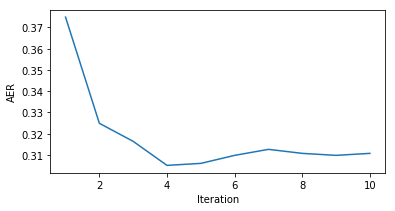

In [58]:
aer_ibm_u = plt.figure(figsize = (6, 3))
plt.plot(iteration_u, AER_u)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm_u.savefig('./result/aer-IBM2-uniform.eps')

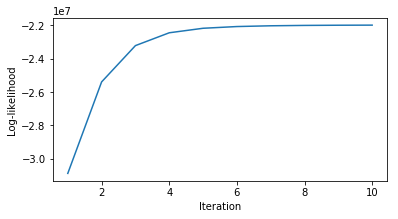

In [59]:
loss_ibm2_u = plt.figure(figsize = (6, 3))
plt.plot(iteration_u, t_log_u)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_u.savefig('./result/loglikelihood-IBM2-uniform.eps')

## * Random Initialization (seed 1)

In [85]:
import random
random.seed(1)
theta_r1 = init_theta(en_train, fr_train)
theta_r1 = init_random(theta_r1, 1)
theta_10_r1, AER_r1, t_log_r1, iteration_r1 = train_EM_ibm2(en_train, fr_train, theta_r1, en_val, fr_val, en_test, fr_test, path_val, K=10, theta_jump='random', seed=1)

Iteration 0:
Validation AER: 0.4693106704438149
Training log-likelihood: -30164709.540037405
Iteration 1:
Validation AER: 0.3559962228517469
Training log-likelihood: -25229454.545183823
Iteration 2:
Validation AER: 0.32672332389046266
Training log-likelihood: -23214107.199544813
Iteration 3:
Validation AER: 0.3106704438149197
Training log-likelihood: -22474229.399151918
Iteration 4:
Validation AER: 0.30028328611898014
Training log-likelihood: -22206332.93030931
Iteration 5:
Validation AER: 0.30689329556185085
Training log-likelihood: -22097899.763697136
Iteration 6:
Validation AER: 0.30689329556185085
Training log-likelihood: -22048626.357998546
Iteration 7:
Validation AER: 0.30783758262511807
Training log-likelihood: -22021560.750409607
Iteration 8:
Validation AER: 0.30783758262511807
Training log-likelihood: -22002978.537652083
Iteration 9:
Validation AER: 0.3097261567516525
Training log-likelihood: -21991716.580732103


## * Testing

In [86]:
aer_test_r1, test_alignment_r1 = compute_aer(en_test, fr_test, path_test, theta_10_r1)
print('Test AER:', aer_test_r1)

Test AER: 0.27468429527926097


## * Plotting

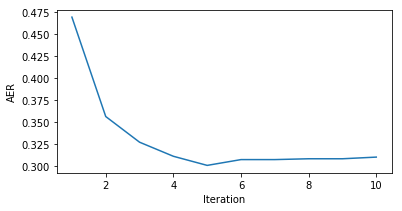

In [87]:
aer_ibm_r1 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r1, AER_r1)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm_r1.savefig('./result/aer-IBM2-random1.eps')

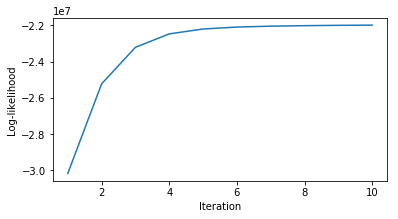

In [88]:
loss_ibm2_r1 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r1, t_log_r1)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_r1.savefig('./result/loglikelihood-IBM2-random1.eps')

## * Random Initialization (seed 2)

In [89]:
import random
random.seed(19)
theta_r2 = init_theta(en_train, fr_train)
theta_r2 = init_random(theta_r2, 19)
theta_10_r2, AER_r2, t_log_r2, iteration_r2 = train_EM_ibm2(en_train, fr_train, theta_r2, en_val, fr_val, en_test, fr_test, path_val, K=10, theta_jump='random', seed=19)

Iteration 0:
Validation AER: 0.46647780925401316
Training log-likelihood: -30129961.545682546
Iteration 1:
Validation AER: 0.3550519357884797
Training log-likelihood: -25176221.625795398
Iteration 2:
Validation AER: 0.32011331444759206
Training log-likelihood: -23132845.483253308
Iteration 3:
Validation AER: 0.3050047214353163
Training log-likelihood: -22384199.433717627
Iteration 4:
Validation AER: 0.30689329556185085
Training log-likelihood: -22129507.244831778
Iteration 5:
Validation AER: 0.30689329556185085
Training log-likelihood: -22036095.143007264
Iteration 6:
Validation AER: 0.3097261567516525
Training log-likelihood: -21998966.633452132
Iteration 7:
Validation AER: 0.31255901794145424
Training log-likelihood: -21985493.577121157
Iteration 8:
Validation AER: 0.30783758262511807
Training log-likelihood: -21981320.250011772
Iteration 9:
Validation AER: 0.3087818696883853
Training log-likelihood: -21978897.330103803


## * Testing

In [90]:
aer_test_r2, test_alignment_r2 = compute_aer(en_test, fr_test, path_test, theta_10_r2)
print('Test AER:', aer_test_r2)

Test AER: 0.27587083651156874


## * Plotting

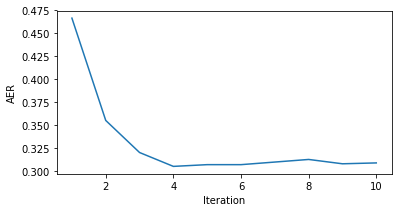

In [91]:
aer_ibm_r2 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r2, AER_r2)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm_r2.savefig('./result/aer-IBM2-random2.eps')

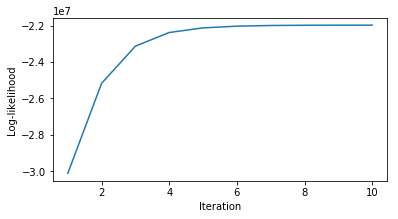

In [92]:
loss_ibm2_r2 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r2, t_log_r2)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_r2.savefig('./result/loglikelihood-IBM2-random2.eps')

## * Random Initialization (seed 3)

In [93]:
import random
random.seed(1)
theta_r3 = init_theta(en_train, fr_train)
theta_r3 = init_random(theta_r3, 1)
theta_10_r3, AER_r3, t_log_r3, iteration_r3 = train_EM_ibm2(en_train, fr_train, theta_r3, en_val, fr_val, en_test, fr_test, path_val, K=10, theta_jump='random', seed=38)

Iteration 0:
Validation AER: 0.4740321057601511
Training log-likelihood: -30181228.25602479
Iteration 1:
Validation AER: 0.3465533522190746
Training log-likelihood: -25134810.740524013
Iteration 2:
Validation AER: 0.31350330500472146
Training log-likelihood: -23045227.024196777
Iteration 3:
Validation AER: 0.30028328611898014
Training log-likelihood: -22328051.15601095
Iteration 4:
Validation AER: 0.2983947119924457
Training log-likelihood: -22107176.969260678
Iteration 5:
Validation AER: 0.3050047214353163
Training log-likelihood: -22028457.275564138
Iteration 6:
Validation AER: 0.3040604343720491
Training log-likelihood: -21997820.883973844
Iteration 7:
Validation AER: 0.3050047214353163
Training log-likelihood: -21980293.874159556
Iteration 8:
Validation AER: 0.30689329556185085
Training log-likelihood: -21969214.110535532
Iteration 9:
Validation AER: 0.3087818696883853
Training log-likelihood: -21964706.720611285


## * Testing

In [94]:
aer_test_r3, test_alignment_r3 = compute_aer(en_test, fr_test, path_test, theta_10_r3)
print('Test AER:', aer_test_r3)

Test AER: 0.27620984829222817


## * Plotting

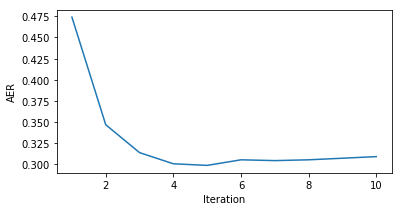

In [95]:
aer_ibm_r3 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r3, AER_r3)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm_r3.savefig('./result/aer-IBM2-random3.eps')

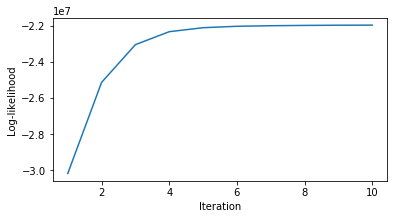

In [96]:
loss_ibm2_r3 = plt.figure(figsize = (6, 3))
plt.plot(iteration_r3, t_log_r3)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_r3.savefig('./result/loglikelihood-IBM2-random3.eps')

## * Initialization with IBM-1 Theta

In [77]:
theta_pt = theta_10
theta_10_pt, AER_pt, t_log_pt, iteration_pt = train_EM_ibm2(en_train, fr_train, theta_pt, en_val, fr_val, en_test, fr_test, path_val, K=10)

Iteration 0:
Validation AER: 0.32483474976392823
Training log-likelihood: -21788608.163745236
Iteration 1:
Validation AER: 0.32011331444759206
Training log-likelihood: -21568501.686846618
Iteration 2:
Validation AER: 0.31350330500472146
Training log-likelihood: -21527165.37642399
Iteration 3:
Validation AER: 0.31255901794145424
Training log-likelihood: -21515147.727678377
Iteration 4:
Validation AER: 0.3106704438149197
Training log-likelihood: -21507376.22589688
Iteration 5:
Validation AER: 0.3106704438149197
Training log-likelihood: -21499716.069472607
Iteration 6:
Validation AER: 0.3087818696883853
Training log-likelihood: -21499211.3970705
Iteration 7:
Validation AER: 0.3097261567516525
Training log-likelihood: -21495543.694312483
Iteration 8:
Validation AER: 0.3097261567516525
Training log-likelihood: -21488232.805973697
Iteration 9:
Validation AER: 0.3087818696883853
Training log-likelihood: -21488169.025394224



## * Testing

In [78]:
aer_test_pt, test_alignment_pt = compute_aer(en_test, fr_test, path_test, theta_10_pt)
print('Test AER:', aer_test_pt)

Test AER: 0.2755318247309094


## * Plotting

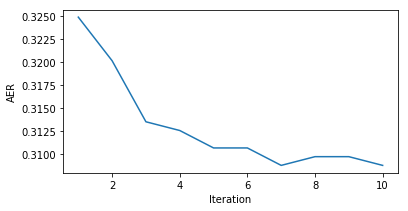

In [79]:
aer_ibm_pt = plt.figure(figsize = (6, 3))
plt.plot(iteration_pt, AER_pt)
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm_pt.savefig('./result/aer-IBM2-pretrained.eps')

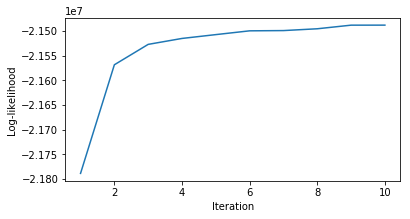

In [80]:
loss_ibm2_pt = plt.figure(figsize = (6, 3))
plt.plot(iteration_pt, t_log_pt)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_pt.savefig('./result/loglikelihood-IBM2-pretrained.eps')

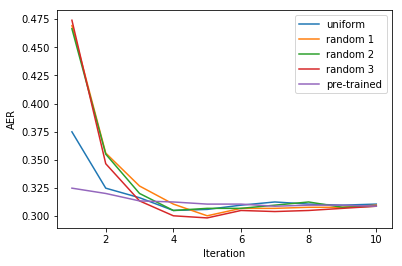

In [97]:
aer_ibm2_all = plt.figure(figsize = (6, 4))
plt.plot(iteration_pt, AER_u, label='uniform')
plt.plot(iteration_pt, AER_r1, label='random 1')
plt.plot(iteration_pt, AER_r2, label='random 2')
plt.plot(iteration_pt, AER_r3, label='random 3')
plt.plot(iteration_pt, AER_pt, label='pre-trained')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('AER')
plt.show()
aer_ibm2_all.savefig('./result/aer-IBM2-all.eps')

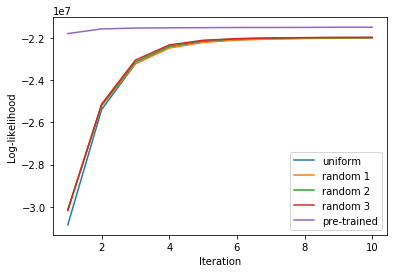

In [98]:
loss_ibm2_all = plt.figure(figsize = (6, 4))
plt.plot(iteration_pt, t_log_u, label='uniform')
plt.plot(iteration_pt, t_log_r1, label='random 1')
plt.plot(iteration_pt, t_log_r2, label='random 2')
plt.plot(iteration_pt, t_log_r3, label='random 3')
plt.plot(iteration_pt, t_log_pt, label='pre-trained')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()
loss_ibm2_all.savefig('./result/loglikelihood-IBM2-all.eps')